In [10]:
import numpy as np
from numpy import sqrt, exp, pi, square
import time

import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import norm, poisson

from numba import int64, float64, guvectorize, jit
from straxen.itp_map import InterpolatingMap
from straxen.common import get_resource,get_to_pe
from straxen import units
import logging
log = logging.getLogger('SimulationCore')


import os
import strax

export, __all__ = strax.exporter()

def data_file_path(filename):
    """Returns filename if a file exists there, else returns PAX_DIR/data/filename"""
    if os.path.exists(filename):
        return filename
    new_filename = os.path.join(PAX_DIR, 'data', filename)
    if os.path.exists(new_filename):
        return new_filename
    else:
        raise ValueError('File name or path %s not found!' % filename)


# Pulse building class
@export
# @strax.takes_config(
#     strax.Option('s1_light_yield_map',default='https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/XENON1T_s1_xyz_ly_kr83m_SR1_pax-680_fdc-3d_v0.json'),
#     strax.Option('s1_patterns_file',default='https://github.com/XENON1T/pax/blob/master/pax/data/XENON1T_s1_xyz_patterns_interp_corrected_MCv2.4.1.json.gz'),
#     strax.Option('s1_ER_alhpae',default=10),
#     strax.Option('s1_ER_alpha_singlet_fraction',default = 10),
#     strax.Option('LED_pulse_length',default=10),
#     strax.Option('Drift_field',default = 50),
#     strax.Option('s1_ER_recombination_time',default=5),
#     strax.Option('s1_ER_primary_singlet_fraction',default=10),
#     strax.Option('Maximum recombination time',default=10),
#     strax.Option('S1_NR_recombination_time',default=10),
#     strax.Option('to_pe_file',default='https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/master/to_pe.npy'),
#     strax.Option('pmt_transit_time_mean',default=10),
#     strax.Option('pmt_transit_time_spread',default=10),
#     strax.Option('sample_duration',default=10),
#     strax.Option('p_double_pe_emision',default=10),
#     strax.Option('samples_before_pulse_center',default=10),
#     strax.Option('samples_after_pulse_center',default=10),
#     strax.Option('pmt_transit_time_mean',default=10),
#     strax.Option('pmt_pulse_time_rounding',default =10),
#     strax.Option('photon_area_distribution',default=10),
#     strax.Option('sample_duration',default=10),
#     strax.Option('s1_detection_efficiency',default=1.),
#     strax.Option('phase',default='liquid')
#     )
class Simulator(strax.Plugin):
    def setup(self):
#        self.s1_light_yield_map = get_resource((self.config['s1_light_yield_map']))
#        self.s1_pattern_map = InterpolatingMap(get_resource(self.config['s1_pattern_map']))
#        self.to_pe = get_to_pe(-1, self.config['to_pe_file'])
        return

class Pulse(object):

    def __call__(self,config):
        """
        PMTs' response to incident photons
        Use _photon_timings, _photon_channels to build pulses
        """
        if '_template_length' not in self.__dict__.keys():
            self.init_pmt_current_templates(config)
        if ('_photon_timings' not in self.__dict__):
            raise NotImplementedError
        # Correct for PMT Transition Time Spread
        self._photon_timings += np.random.normal(config['pmt_transit_time_mean'],
                                                 config['pmt_transit_time_spread'],
                                                 len(self._photon_timings))

        _channel_photon_timings = self._photon_timings

        # Compute sample index（quotient）and reminder
        # Determined by division between photon timing and sample duraiton.
        dt = config['sample_duration']
        _channel_photon_reminders = (_channel_photon_timings -
                                     np.floor(_channel_photon_timings/dt).astype(int)*dt).astype(int)
        _channel_photon_timings = np.floor(_channel_photon_timings/dt).astype(int)

        # If gain of each photon is not specifically assigned
        # Sample from spe scaling factor distribution and to individual gain
        if '_photon_gains' not in self.__dict__:
            _channel_photon_gains = np.average(self.to_pe) * (np.random.random(len(_channel_photon_timings)))

            # Effectively adding double photoelectron emission by doubling gain
            n_double_pe = np.random.binomial(len(_channel_photon_timings),
                                             p=config['p_double_pe_emision'])
            _dpe_index = np.random.choice(np.arange(len(_channel_photon_timings)),
                                          size=n_double_pe, replace=False)
            _channel_photon_gains[_dpe_index] += np.average(self.to_pe) \
                * (np.random.random(n_double_pe))
        else:
            _channel_photon_gains = self._photon_gains[self._photon_channels == channel]

        # Build a simulated waveform, length depends on min and max of photon timings
        min_timing, max_timing = np.min(
            _channel_photon_timings), np.max(_channel_photon_timings)
        pulse_left = min_timing - int(config['samples_before_pulse_center'])
        pulse_right = max_timing + int(config['samples_after_pulse_center'])
        pulse_current = np.zeros(pulse_right - pulse_left + 1)
        Pulse.add_current(_channel_photon_timings - min_timing,
                          _channel_photon_reminders, _channel_photon_gains, pulse_current)

        # For single event, data of pulse level is small enough to store in dataframe
        result = np.zeros(1,dtype=strax.peak_dtype(len(self.to_pe)))
        result['channel'] = -1
        result['data'][:,10:10+len(pulse_current)] += pulse_current #bad, TODO!

        return result

    def init_pmt_current_templates(self,config):
        """
        Create spe templates, for 10ns sample duration and 1ns rounding we have:
        _pmt_current_templates[i] : photon timing fall between [10*m+i, 10*m+i+1)
        (i, m are integers)
        """
        # 'Hidden' global variables to avoid passing class instance into guvectorized function
        global _pmt_current_templates, _template_length
        _pmt_current_templates = []
        _template_length = 0

        # Interpolate on cdf ensures that each spe pulse would sum up to 1 pe*sample duration^-1
        pe_pulse_function = interp1d(
            config['pe_pulse_ts'],
            np.cumsum(config['pe_pulse_ys']),
            bounds_error=False, fill_value=(0, 1))

        # Samples are always multiples of sample_duration
        sample_duration = config.get('sample_duration', 10)
        samples_before = config.get('samples_before_pulse_center', 2)
        samples_after = config.get('samples_after_pulse_center', 20)
        pmt_pulse_time_rounding = config.get('pmt_pulse_time_rounding', 1.0)

        samples = np.linspace(-samples_before * sample_duration,
                              + samples_after * sample_duration,
                              1 + samples_before + samples_after)
        _template_length = len(samples) - 1

        for r in np.arange(0, sample_duration, pmt_pulse_time_rounding):
            pmt_current = np.diff(pe_pulse_function(samples - r)) / sample_duration  # pe / 10 ns
            # Normalize here to counter tiny rounding error from interpolation
            pmt_current *= (1 / sample_duration) / np.sum(pmt_current)  # pe / 10 ns
            _pmt_current_templates.append(pmt_current)
        self._template_length = _template_length

        log.debug('Create spe waveform templates with %s ns resolution' % pmt_pulse_time_rounding)

    def clear_pulse_cache(self):
        self._pulses = []

    @staticmethod  # Staticmethod decorator doesn't seem to do anything
    @guvectorize([(int64, int64, float64, float64[:])], '(), (), (), (n)')
    def add_current(_photon_timing_start, _reminder, _photon_gain, pulse):
        """
        Simulate single channel waveform given the photon timings
        _photon_timing_start   - dim-1 integer array of photon timings in unit of samples
        _reminder              - dim-1 integer array of complimentary photon timings
        _photon_gain           - dim-1 float array of ph. 2 el. gain individual photons
        _pulse                 - waveform
        _pmt_current_templates - list of spe templates of different reminders
        The self argument is intentionally left out of this function.
        """
        pulse[_photon_timing_start:_photon_timing_start+_template_length] +=  _photon_gain

    def singlet_triplet_delays(self, size, singlet_ratio,config):
        """
        Given the amount of the eximer, return time between excimer decay
        and their time of generation.
        size           - amount of eximer
        self.phase     - 'liquid' or 'gas'
        singlet_ratio  - fraction of excimers that become singlets
                         (NOT the ratio of singlets/triplets!)
        """
        if config['phase'] == 'liquid':
            t1, t3 = (config['singlet_lifetime_liquid'],
                      config['triplet_lifetime_liquid'])
        elif config['phase'] == 'gas':
            t1, t3 = (config['singlet_lifetime_gas'],
                      config['triplet_lifetime_gas'])

        delay = np.random.choice([t1, t3], size, replace=True,
                                 p=[singlet_ratio, 1-singlet_ratio])
        return np.random.exponential(1, size) * delay

@export

class S1(Pulse):
    depends_on = tuple()

    def simulate(self,data,i,config):
        """
        Given temperal inputs as well as number of photons
        Random generate photon timing and channel distribution.
        """

        self.s1_light_yield_map = InterpolatingMap(get_resource('https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/'+config['s1_light_yield_map'],fmt='json'))
        self.s1_pattern_map = InterpolatingMap(get_resource('https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/'+config['s1_pattern_map'],fmt='json.gz'))
        self.to_pe = get_to_pe(-1, config['to_pe_file'])

        ly = self.s1_light_yield_map([i['x'],i['y'],i['z']])*config['s1_detection_efficiency']

        n_photons = np.random.binomial(n=i['n_photons'], p=ly)

        self.photon_timings(i['t'], i['n_photons'], i['recoil_type'],config)
        # The new way iterpolation is written always require a list
        data = super().__call__(config)
        return data

    def photon_timings(self, t, n_photons, recoil_type,config):
        if n_photons == 0:
            self._photon_timings = np.array([])
            return 0
        try:
            x = getattr(self,recoil_type)
        except AttributeError:
            raise AttributeError('Recoil type must be ER, NR, alpha or LED, not %s' % recoil_type)

        self._photon_timings = t + x(n_photons,config)

    def alpha(self, size):
        # Neglible recombination time
        return self.singlet_triplet_delays(size, config['s1_ER_alpha_singlet_fraction'])

    def led(self, size):
        # distribute photons uniformly within the LED pulse length
        return np.random.uniform(0, config['led_pulse_length'], size)

    def er(self, size,config):
        # How many of these are primary excimers? Others arise through recombination.
        efield = (config['drift_field'] / (units.V / units.cm))
        config['s1_ER_recombination_time'] = 3.5 / \
            0.18 * (1 / 20 + 0.41) * np.exp(-0.009 * efield)

        reco_time, p_fraction, max_reco_time = (
            config['s1_ER_recombination_time'],
            config['s1_ER_primary_singlet_fraction'],
            config['maximum_recombination_time'])

        timings = np.random.choice([0, reco_time], size, replace=True,
                                   p=[p_fraction, 1-p_fraction])
        primary = timings == 0
        timings *= 1 / (1-np.random.uniform(0, 1, size)) - 1
        timings = np.clip(timings, 0, config['maximum_recombination_time'])
        size_primary = len(timings[primary])
        timings[primary] += self.singlet_triplet_delays(
            size_primary, config['s1_ER_primary_singlet_fraction'],config)
        timings[~primary] += self.singlet_triplet_delays(
            size-size_primary, config['s1_ER_secondary_singlet_fraction'],config)
        return timings

    def nr(self, size):
        return self.singlet_triplet_delays(size, config['s1_NR_singlet_fraction'])


class S2(Pulse):
    """
    Given temperal inputs as well as number of electrons
    Random generate photon timing and channel distribution.
    """

    def __init__(self, config):
        super().__init__(config)

        self.s2_light_yield_map = InterpolatingMap(
            utils.data_file_name(self.config['s2_light_yield_map']))
        self.s2_pattern_map = InterpolatingMap(
            utils.data_file_name(self.config['s2_patterns_file']))
        self.phase = 'gas'  # To distinguish singlet/triplet time delay.
        self.luminescence_switch_threshold = 100  # More then those electrons use simplified luminescence model





    def __call__(self, instruction):
        if isinstance(instruction, list) or len(instruction.shape) < 2:
            instruction = np.array([instruction])

        _, _, t, x, y, z, n_electron, recoil_type = [
            np.array(v).reshape(-1) for v in zip(*instruction)]

        poistions = np.array([x, y]).T  # For map interpolation
        sc_gain = self.s2_light_yield_map(poistions) * self.config['s2_secondary_sc_gain']

        # Average drift time of the electrons
        self.drift_time_mean = - z / \
            self.config['drift_velocity_liquid'] + self.config['drift_time_gate']

        # Absorb electrons during the drift
        electron_lifetime_correction = np.exp(- 1 * self.drift_time_mean /
                                              self.config['electron_lifetime_liquid'])
        cy = self.config['electron_extraction_yield'] * electron_lifetime_correction
        n_electron = np.random.binomial(n=list(n_electron), p=cy)

        # Second generate photon timing and channel
        self.photon_timings(t, n_electron, z, sc_gain)
        self.photon_channels(poistions)

        super().__call__()

    def luminescence_timings(self, shape):
        """
        Luminescence time distribution computation
        """
        number_density_gas = self.config['pressure'] / \
            (units.boltzmannConstant * self.config['temperature'])
        alpha = self.config['gas_drift_velocity_slope'] / number_density_gas

        dG = self.config['elr_gas_gap_length']
        rA = self.config['anode_field_domination_distance']
        rW = self.config['anode_wire_radius']
        dL = self.config['gate_to_anode_distance'] - dG

        VG = self.config['anode_voltage'] / (1 + dL/dG/self.config['lxe_dielectric_constant'])
        E0 = VG/((dG - rA)/rA + np.log(rA/rW))

        def Efield_r(r): return np.clip(E0/r, E0/rA, E0/rW)

        def velosity_r(r): return alpha * Efield_r(r)

        def Yield_r(r): return Efield_r(r) / (units.kV / units.cm) - \
            0.8 * self.config['pressure'] / units.bar

        r = np.linspace(dG, rW, 1000)
        dt = - np.diff(r)[0] / velosity_r(r)
        dy = Yield_r(r)/np.sum(Yield_r(r))

        uniform_to_emission_time = interp1d(np.cumsum(dy), np.cumsum(dt),
                                            bounds_error=False, fill_value=(0, sum(dt)))

        probabilities = 1 - np.random.uniform(0, 1, size=shape)
        return uniform_to_emission_time(probabilities)

    def electron_timings(self, t, n_electron, z, sc_gain):

        # Diffusion model from Sorensen 2011
        drift_time_mean = - z / \
            self.config['drift_velocity_liquid'] + self.config['drift_time_gate']
        drift_time_stdev = np.sqrt(2 * self.config['diffusion_constant_liquid'] * drift_time_mean)
        drift_time_stdev /= self.config['drift_velocity_liquid']

        # Calculate electron arrival times in the ELR region
        _electron_timings = t + \
            np.random.exponential(self.config['electron_trapping_time'], n_electron)
        if drift_time_stdev:
            _electron_timings += np.random.normal(drift_time_mean, drift_time_stdev, n_electron)

        self._electron_timings = np.append(self._electron_timings, _electron_timings)
        self._electron_gains = np.append(
            self._electron_gains, np.repeat(sc_gain, len(_electron_timings)))

    def photon_timings(self, t, n_electron, z, sc_gain):
        # First generate electron timing
        self._electron_timings = np.array([])
        self._electron_gains = np.array([])
        list(map(self.electron_timings, t, n_electron, z, sc_gain))

        # TODO log this
        if len(self._electron_timings) < 1:
            self._photon_timings = []
            return 1

        # For vectorized calculation, artificially top #photon per electron at +4 sigma
        nele = len(self._electron_timings)
        npho = np.ceil(np.max(self._electron_gains) +
                       4 * np.sqrt(np.max(self._electron_gains))).astype(int)

        self._photon_timings = self.luminescence_timings((nele, npho))
        self._photon_timings += np.repeat(self._electron_timings, npho).reshape((nele, npho))

        # Crop number of photons by random number generated with poisson
        probability = np.tile(np.arange(npho), nele).reshape((nele, npho))
        threshold = np.repeat(np.random.poisson(self._electron_gains), npho).reshape((nele, npho))
        self._photon_timings = self._photon_timings[probability < threshold]

        # Special index for match photon to original electron poistion
        self._instruction = np.repeat(
            np.repeat(np.arange(len(t)), n_electron), npho).reshape((nele, npho))
        self._instruction = self._instruction[probability < threshold]

        self._photon_timings += self.singlet_triplet_delays(
            len(self._photon_timings), self.config['singlet_fraction_gas'])

    def photon_channels(self, points):
        # TODO log this
        if len(self._photon_timings) == 0:
            self._photon_channels = []
            return 1

        # Probability of each top channel given area fraction top
        p_top = self.config['s2_mean_area_fraction_top']
        # A fraction of photons are given uniformally to top pmts regardless of pattern
        p_random = self.config.get('randomize_fraction_of_s2_top_array_photons', 0)
        # Use pattern to get top channel probability
        # p_pattern = self.s2_pattern_map(points)
        p_pattern = self.s2_pattern_map_pp(points)

        # Probability of each bottom channels
        p_per_channel_bottom = (1-p_top) / len(self.config['channels_bottom']) \
            * np.ones_like(self.config['channels_bottom'])

        # Randomly assign to channel given probability of each channel
        # Sum probabilities over channels should be 1
        self._photon_channels = np.array([])
        for u, n in zip(*np.unique(self._instruction, return_counts=True)):
            p_per_channel_top = p_pattern[u] / np.sum(p_pattern[u]) * p_top * (1 - p_random)
            channels = np.array(self.config['channels_in_detector']['tpc'])
            p_per_channel = np.concatenate([p_per_channel_top, p_per_channel_bottom])
            # p_per_channel[np.in1d(channels, self.turned_off_pmts)] = 0

            _photon_channels = np.random.choice(
                channels,
                size=n,
                p=p_per_channel/np.sum(p_per_channel),
                replace=True)

            self._photon_channels = np.append(self._photon_channels, _photon_channels)

        self._photon_channels = self._photon_channels.astype(int)

    def s2_pattern_map_pp(self, pos):
        if 'params' not in self.__dict__:
            all_map_params = pd.read_pickle(
                '/Users/petergaemers/Desktop/python/WFSimDev/Kr83m_Ddriven_per_pmt_params_dataframe.pkl')
            self.params = all_map_params.loc[all_map_params.kr_run_id == 10,
                                             ['amp0', 'amp1', 'tao0', 'tao1', 'pmtx', 'pmty']].values.T

        amp0, amp1, tao0, tao1, pmtx, pmty = self.params

        def rms(x, y): return np.sqrt(np.square(x) + np.square(y))

        distance = rms(pmtx - pos[:, 0].reshape([-1, 1]), pmty - pos[:, 1].reshape([-1, 1]))
        frac = amp0 * np.exp(- distance / tao0) + amp1 * np.exp(- distance / tao1)
        frac = (frac.T / np.sum(frac, axis=-1)).T

        return frac





In [2]:
import numpy as np
import strax
import os
import straxen


export, __all__ = strax.exporter()

def rand_instructions(n=10):
    nelectrons = 10 ** (np.random.uniform(1, 4.8, n))

    instructions = np.zeros(2 * n, dtype=[('event_number', np.int), ('type', '<U2'), ('t', np.int), ('x', np.float32),
                                          ('y', np.float32), ('z', np.float32), ('amp', np.int), ('recoil', '<U2')])
    instructions['event_number'] = np.repeat(np.arange(n), 2)
    instructions['type'] = np.tile(['s1', 's2'], n)
    instructions['t'] = np.ones(n * 2) * 1e6
    r = np.sqrt(np.random.uniform(0, 2500, n))
    phi = np.random.uniform(-np.pi, np.pi, n)

    instructions['x'] = np.repeat(r * np.cos(phi), 2)
    instructions['y'] = np.repeat(r * np.sin(phi), 2)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 2)
    instructions['amp'] = np.vstack(
        [np.random.uniform(3000, 3001, n), nelectrons]).T.flatten().astype(int)
    instructions['recoil'] = ['er' for i in range(n * 2)]

    return instructions

def rand_instructions_s1(n=10):
    nelectrons = 10 ** (np.random.uniform(1, 4.8, n))

    instructions = np.zeros(n, dtype=[('event_number', np.int), ('type', '<U2'), ('t', np.int), ('x', np.float32),
                                          ('y', np.float32), ('z', np.float32), ('amp', np.int),('n_photons',np.int), ('recoil_type', '<U2')])
    instructions['event_number'] = np.repeat(np.arange(n),1)
    instructions['type'] = 's1'
    instructions['t'] = np.ones(n ) * 1e6
    r = np.sqrt(np.random.uniform(0, 2500, n))
    phi = np.random.uniform(-np.pi, np.pi, n)

    instructions['x'] = np.repeat(r * np.cos(phi),1)
    instructions['y'] = np.repeat(r * np.sin(phi),1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n),1)
    instructions['amp'] = np.random.uniform(3000, 3001, n)
    instructions['n_photons'] = nelectrons
    instructions['recoil_type'] = ['er' for i in range(n)]

    return instructions

def fax_to_peaks(f,config):
    

    # if f.type = str():
    #     with open(file) as f:
    #         reader = csv.reader(f, delimiter=',')
    #         puls = list()
    #         for row in reader:
    #             if reader.line_num == 1:
    #                 continue
    #             for i in range(int(row[5]) + int(row[6])):
    #                 puls.extend(simulate_pulse(row[0], row[7]))
    #     pulses = np.zeros(len(puls), dtype=[('event', np.int), ('channel', np.int), ('time', (np.float, 100)),
    #                                         ('signal', (np.float, 100))])
    #     for i in range(len(puls)):
    #         pulses[i] = puls[i]


 #   if f.type = int()
 #    pulses = np.zeros(f,dtype=[('event', np.int), ('channel', np.int), ('time', (np.float, 100)),
 #                                        ('signal', (np.float, 100))])
    instructions = rand_instructions_s1(f)
    peaks = np.zeros(f,dtype=strax.peak_dtype(248))
    for i,instruction in enumerate(instructions):
        peaks[i] = straxen.plugins.fax.S1().simulate(peaks[i],instruction,config)

    yield peaks
    
@export
@strax.takes_config(
    strax.Option('fax_file', default=None, track=False,
                 help="Directory with fax instructions"),
    strax.Option('nevents',default = 10,track=False,
                help="Number of random events to generate if no instructions are provided"),
    strax.Option('events_per_chunk', default=50, track=False,
                 help="Number of events to yield per chunk"),
    strax.Option('samples_per_record', default=strax.DEFAULT_RECORD_LENGTH, track=False,
                 help="Number of samples per record"),
    strax.Option(
        'to_pe_file',
        default='https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/master/to_pe.npy',
        help='link to the to_pe conversion factors'),
    strax.Option('s1_light_yield_map',default='https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/XENON1T_s1_xyz_ly_kr83m_SR1_pax-680_fdc-3d_v0.json'),
    strax.Option('s1_pattern_map',default='https://raw.githubusercontent.com/XENON1T/pax/master/pax/data/XENON1T_s1_xyz_patterns_interp_corrected_MCv2.4.1.json.gz'),
    # strax.Option('s1_ER_alhpae',default=10),
    # strax.Option('s1_ER_alpha_singlet_fraction',default = 0.01),
    # strax.Option('LED_pulse_length',default=1e1),
    # strax.Option('drift_field',default = 50),
    # strax.Option('s1_ER_recombination_time',default=1),
    # strax.Option('s1_ER_primary_singlet_fraction',default=0.01),
    # strax.Option('s1_ER_secondary_singlet_fraction',default=0.01),
    # strax.Option('maximum_recombination_time',default=50.),
    # strax.Option('S1_NR_recombination_time',default=1.),
    # strax.Option('to_pe_file',default='https://raw.githubusercontent.com/XENONnT/strax_auxiliary_files/master/to_pe.npy'),
    # strax.Option('pmt_transit_time_mean',default=12.),
    # strax.Option('pmt_transit_time_spread',default=14.),
    # strax.Option('sample_duration',default=10),
    # strax.Option('p_double_pe_emision',default=0.5),
    # strax.Option('samples_before_pulse_center',default=10),
    # strax.Option('samples_after_pulse_center',default=10),
    # strax.Option('pmt_pulse_time_rounding',default =10),
    # strax.Option('photon_area_distribution',default=0.1),
    # strax.Option('sample_duration',default=10),
    # strax.Option('s1_detection_efficiency',default=.001),
    # strax.Option('phase',default='liquid'),
    # strax.Option('singlet_lifetime_liquid',default=1.e-1),
    # strax.Option('triplet_lifetime_liquid',default=1.e-1),
    # strax.Option('pe_pulse_ts',default=[-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]),
    # strax.Option('pe_pulse_ys',default= [1.18008086046e-13, 2.01510001127e-11, 1.79965780012e-09, 8.48007314484e-08, 2.14369872461e-06, 3.0103039879e-05, 0.000252465494218, 0.00142372973015, 0.00594658692409, 0.0181027762995, 0.0378550569464, 0.0548947436835, 0.0607148468144, 0.0584407043053, 0.0538666257444, 0.049285064956, 0.0450635550292, 0.0412023916068, 0.0376720355609, 0.0344441716911, 0.0314928818088, 0.0287944681474, 0.0263272634409, 0.0240714569457, 0.0220089353681, 0.0201231374208, 0.0183989208421, 0.016822440809, 0.0153810387686, 0.0137867416949, 0.0123374131303, 0.00632022273936, 0.00594109035522, 0.00556195797109, 0.00518282558696, 0.00480369320282, 0.00442456081869, 0.00404542843455, 0.00366629605042, 0.00330303609974, 0.00295564858253, 0.00289396486761, 0.0028322811527, 0.00277059743778, 0.00270891372286, 0.00264723000794, 0.00258554629303, 0.00252386257811, 0.00246217886319, 0.00240161621109, 0.0023421746218, 0.00230291216317, 0.00226364970454, 0.00222438724591, 0.00218512478727, 0.00214586232864, 0.00210659987001, 0.00206733741138, 0.00202807495275, 0.00198974698459, 0.0019523535069, 0.00193178085771, 0.00191120820851, 0.00189063555931, 0.00187006291012, 0.00184949026092, 0.00182891761173, 0.00180834496253, 0.00178777231334, 0.00176727799968, 0.00174686202156, 0.00172785608315, 0.00170885014474, 0.00168984420633, 0.00167083826791, 0.0016518323295, 0.00163282639109, 0.00161382045268, 0.00159481451426, 0.00157618468749, 0.00155793097236, 0.00154644726676, 0.00153496356117, 0.00152347985557, 0.00151199614997, 0.00150051244438, 0.00148902873878, 0.00147754503318, 0.00146606132759, 0.00145456952089, 0.00144306961308, 0.00143142388541, 0.00141977815774, 0.00140813243006, 0.00139648670239, 0.00138484097471, 0.00137319524704, 0.00136154951937, 0.00134990379169, 0.00133936312617, 0.0013299275228, 0.00134038303817, 0.00135083855354, 0.00136129406891, 0.00137174958428, 0.00138220509965, 0.00139266061502, 0.00140311613039, 0.00141357164576, 0.0014245434863, 0.00143603165202, 0.00145681367089, 0.00147759568976, 0.00149837770863, 0.0015191597275, 0.00153994174637, 0.00156072376524, 0.0015815057841, 0.00160228780297, 0.00162151412482, 0.00163918474964, 0.001628852828, 0.00161852090637, 0.00160818898473, 0.0015978570631, 0.00158752514146, 0.00157719321983, 0.00156686129819, 0.00155652937656, 0.00154540666555, 0.00153349316516, 0.00150734545599, 0.00148119774682, 0.00145505003766, 0.00142890232849, 0.00140275461932, 0.00137660691016, 0.00135045920099, 0.00132431149182, 0.00129884549887, 0.00127406122213, 0.00126154783725, 0.00124903445237, 0.00123652106748, 0.0012240076826, 0.00121149429772, 0.00119898091283, 0.00118646752795, 0.00117395414307, 0.0011621578489, 0.00115107864546, 0.00115290707493, 0.0011547355044, 0.00115656393387, 0.00115839236335, 0.00116022079282, 0.00116204922229, 0.00116387765176, 0.00116570608124, 0.0011670716643, 0.00116797440097, 0.00116054590234, 0.00115311740372, 0.0011456889051, 0.00113826040648, 0.00113083190786, 0.00112340340924, 0.00111597491062, 0.001108546412, 0.00109849237286, 0.0010858127932, 0.00102587348421, 0.000965934175218, 0.000905994866227, 0.000846055557235, 0.000786116248244, 0.000726176939252, 0.000666237630261, 0.000606298321269, 0.000548218272083, 0.000491997482703, 0.000469243369824, 0.000446489256945, 0.000423735144066, 0.000400981031187, 0.000378226918308, 0.000355472805429, 0.00033271869255, 0.000309964579671, 0.000287844335944, 0.000266357961371, 0.000256281231553, 0.000246204501734, 0.000236127771915, 0.000226051042096, 0.000215974312277, 0.000205897582458, 0.000195820852639, 0.00018574412282, 0.000176132715964, 0.000166986632072, 0.000166216361511, 0.00016544609095, 0.00016467582039, 0.000163905549829, 0.000163135279268, 0.000162365008708, 0.000161594738147, 0.000160824467586])
    # ,
    strax.Option('fax_config', default='https://github.com/XENONnT/strax_auxiliary_files/blob/master/fax_config.json?raw=true'),
    strax.Option('phase', default='liquid')
)
class PeaksFromFax(strax.Plugin):
    provides = 'peaks'
    data_kind = 'peaks'
    compressor = 'zstd'
    depends_on = tuple()
    parallel = False
    rechunk_on_save = False
    def infer_dtype(self):
        self.to_pe = straxen.common.get_to_pe(self.run_id,self.config['to_pe_file'])

        return strax.peak_dtype(len(self.to_pe))

    def setup(self):
        self.config.update(straxen.common.get_resource(self.config['fax_config'],fmt='json'))

    def iter(self, *args, **kwargs):
#        if not os.path.exists(self.config['fax_file']):
#            raise FileNotFoundError(self.config['fax_file'])
#        if not strax.config['fax_file']:
        yield from fax_to_peaks(self.config['nevents'],self.config)
#                random(self.config['nevents']),)


        # else:
        #     yield from fax_to_records(
        #         self.config['fax_file'],)

In [4]:
file ='./XENON1T_dummy_waveforms.csv'
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.signal

import strax
import straxen

st = strax.Context(
        storage=[
            strax.DataDirectory('./',)],
    
        register=straxen.plugins.fax_interface.PeaksFromFax,
        # When asking for runs that don't exist, throw an error rather than
        # starting the pax converter
#        forbid_creation_of=('raw_records',),
#        **straxen.contexts.common_opts
)

In [5]:
p = st.get_array('10','peaks')

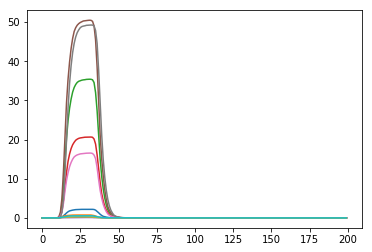

In [6]:
plt.plot(p['data'].T)

In [1]:
!rm -r resource_cache/